In [58]:
import cv2
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [59]:
# Holistic model
mp_holistic = mp.solutions.holistic
# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

In [60]:
def mediapipe_detection(frame, model):
    # COLOR CONVERSION BGR 2 RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame.flags.writeable = False                  # Image is no longer writeable
    results = model.process(frame)                 # Make prediction
    frame.flags.writeable = True                   # Image is now writeable
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return frame, results

In [61]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,
                              mp_holistic.FACEMESH_CONTOURS)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks,
                              mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw right hand connections

In [62]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(
                                  color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(
                                  color=(80, 256, 121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(80, 44, 121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(121, 44, 250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(245, 66, 230), thickness=2, circle_radius=2)
                              )

In [63]:
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        cv2.startWindowThread()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [64]:
draw_landmarks(frame, results)

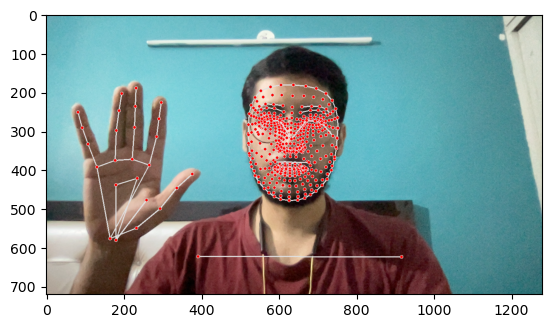

In [65]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [66]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [67]:
pose = np.array([[res.x, res.y, res.z, res.visibility]
                 for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z]
                 for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z]
               for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z]
               for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [68]:
pose

array([ 4.95244741e-01,  4.46269989e-01, -7.71981537e-01,  9.99921799e-01,
        5.25282502e-01,  3.80463868e-01, -7.20744967e-01,  9.99803543e-01,
        5.42893410e-01,  3.83175373e-01, -7.20660567e-01,  9.99764621e-01,
        5.55800319e-01,  3.87969196e-01, -7.20538020e-01,  9.99761462e-01,
        4.71545517e-01,  3.79585534e-01, -7.02358007e-01,  9.99836028e-01,
        4.54116911e-01,  3.81581962e-01, -7.01892257e-01,  9.99839246e-01,
        4.41029370e-01,  3.84957790e-01, -7.02131987e-01,  9.99880612e-01,
        5.78830898e-01,  4.34848279e-01, -4.11548138e-01,  9.99728858e-01,
        4.28494304e-01,  4.30371463e-01, -3.11564714e-01,  9.99867857e-01,
        5.30437350e-01,  5.29216230e-01, -6.64870381e-01,  9.99874473e-01,
        4.62105453e-01,  5.27898610e-01, -6.37383521e-01,  9.99912262e-01,
        7.16421723e-01,  8.67428780e-01, -2.64220268e-01,  9.95667636e-01,
        3.06813687e-01,  8.65703642e-01, -1.77451313e-01,  9.98958349e-01,
        8.30687881e-01,  

In [69]:
face = np.array([[res.x, res.y, res.z]
                 for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [70]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility]
                     for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z]
                     for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z]
                   for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z]
                   for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [71]:
result_test = extract_keypoints(results)

In [72]:
result_test

array([ 0.49524474,  0.44626999, -0.77198154, ...,  0.06430115,
        0.35126537, -0.05668411])

In [73]:
np.save('Result_Test_Value', result_test)

In [74]:
np.load('Result_Test_Value.npy')

array([ 0.49524474,  0.44626999, -0.77198154, ...,  0.06430115,
        0.35126537, -0.05668411])

In [75]:
DATA_PATH = os.path.join('/Users/utkx2/Desktop/python/MLDL/Projects/Human-Action-Recognition/MP_Data')

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [76]:
for action in actions: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [77]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV data collection Feed', image)
                    cv2.waitKey(60)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV data collection Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [78]:
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [79]:
label_map = {label:num for num, label in enumerate(actions)}

In [80]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [81]:
sequences = []
labels = []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [82]:
np.array(sequences).shape

(90, 30, 1662)

In [83]:
np.array(labels).shape

(90,)

In [84]:
X = np.array(sequences)

In [85]:
X.shape

(90, 30, 1662)

In [86]:
y = to_categorical(labels).astype(int)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [88]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(85, 30, 1662)
(85, 3)
(5, 30, 1662)
(5, 3)


In [89]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [90]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(actions.shape[0], activation='softmax'))

In [91]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [92]:
# Train your model
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
3/3 [==============================] - 15s 4s/step - loss: 1.8424 - categorical_accuracy: 0.3647
Epoch 2/100
3/3 [==============================] - 9s 3s/step - loss: 1.1211 - categorical_accuracy: 0.3647
Epoch 3/100
3/3 [==============================] - 10s 3s/step - loss: 2.6275 - categorical_accuracy: 0.3647
Epoch 4/100
3/3 [==============================] - 10s 3s/step - loss: 1.3602 - categorical_accuracy: 0.3294
Epoch 5/100
3/3 [==============================] - 10s 3s/step - loss: 1.1001 - categorical_accuracy: 0.4000
Epoch 6/100
3/3 [==============================] - 10s 3s/step - loss: 1.1098 - categorical_accuracy: 0.3176
Epoch 7/100
3/3 [==============================] - 11s 4s/step - loss: 1.1052 - categorical_accuracy: 0.2353
Epoch 8/100
3/3 [==============================] - 11s 4s/step - loss: 1.0858 - categorical_accuracy: 0.4000
Epoch 9/100
3/3 [==============================] - 11s 4s/step - loss: 1.1021 - categorical_accuracy: 0.3294
Epoch 10/100
3/3 [==

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [94]:
result = model.predict(X_test)

1/1 [==============================] - 1s 648ms/step


In [95]:
actions[np.argmax(result[4])]

'hello'

In [96]:
actions[np.argmax(y_test[4])]

'thanks'

In [97]:
model.save('action.h5')

In [98]:
model.load_weights('action.h5')

In [99]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 241ms/step


In [100]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [101]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 1],
        [3, 0]],

       [[4, 0],
        [1, 0]],

       [[1, 3],
        [0, 1]]])

In [102]:
accuracy_score(ytrue, yhat)

0.2

In [103]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [105]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        if num < len(colors):
            cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
            cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame


In [106]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [107]:
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1